# **Bioactivity prediction**
---
Made by: Norberto Sánchez Cruz

Contact: norberto.sanchez@iquimica.unam.mx

**Last Update:** October 2025

# Content
---

>[Bioactivity prediction](#scrollTo=UpELbv9BKPwb&line=7&uniqifier=1)

>[Content](#scrollTo=86223IH0Kg05&line=2&uniqifier=1)

>[Objectives]

>[Introduction]

>[Exercises]

>>[Similarity search]

>>>[Data loading and standardization.]

>>>[Selection of a fingerprint representation.]

>>>[Seleccion of a similarity metric.]

>>>[Visual inspection.]

>>>[Definition of a query.]

>>[Bioactivity prediction]

>>>[Endpoint definition.]

>>>[Model building and evaluation.]

>>>[Model application.]

>>>[Interpreting the results.]

>[For more information:]

# Objectives
---
- Understand how representation and metric affect **molecular similarity**.
- Build a minimal, reproducible **QSAR/ML pipeline** aligned with OECD principles.
- Prioritize a generated library by **similarity**, and by **model score**.

# Introduction

This hands-on module complements the first block by using the generated library and a target-specific ChEMBL set to perform two tasks: (i) rapid similarity search for nearest-neighbor retrieval, and (ii) bioactivity prediction (QSAR/ML). We rely on compact, transparent representations—primarily ECFP4 fingerprints—and standard metrics (e.g., Tanimoto) to keep the workflow fast, reproducible, and easy to interpret.

**Data** used in this notebook:
- **Target dataset** from ChEMBL (SMILES + pKi) for the Phosphatidylinositol 4,5-bisphosphate 3-kinase catalytic subunit alpha isoform (**CHEMBL4005_Ki.csv**).
- **Generated library of bezoxazoles** ("benzoxazoles.csv").

# Excercises
---

## Similarity search

### 1. Data loading and standardization.

a) Install packages and modules

In [7]:
! pip install rdkit
! pip install chembl-structure-pipeline

b) Import packages and modules

In [251]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import PandasTools

from chembl_structure_pipeline import standardizer

from scipy.spatial.distance import pdist, cdist, squareform

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score

from tqdm import tqdm

tqdm.pandas()

c) Load data as pandas dataframes

In [11]:
chembl_data = pd.read_csv("CHEMBL4005_Ki.csv")
chembl_data.head()

,Molecule ChEMBL ID,Smiles,pChEMBL Value,Assay ChEMBL ID
0,CHEMBL2165040,c1cnc(Nc2cccc3n[nH]cc23)c(-c2ncnc3nc[nH]c23)c1,4.64,CHEMBL3706341
1,CHEMBL4293439,C[C@@H]1CN(c2nc(-c3cnc(N)cc3C(F)F)nc(N3C[C@@H]...,4.81,CHEMBL4276427
2,CHEMBL3698320,Cc1nc2ccc(Cl)cc2c(N2CC(C)(C)c3ccc(-c4cn[nH]c4)...,5.02,CHEMBL3705734
3,CHEMBL4288989,CC1(C)CN(c2nc(-c3cnc(N)cc3C(F)F)nc(N3CCOC(C)(C...,5.06,CHEMBL4276427
4,CHEMBL3698332,COc1cc2nc(C)c(C)c(N3CC4(CCOCC4)c4ccc(C#N)cc43)...,5.12,CHEMBL3705734


In [12]:
benzoxazoles = pd.read_csv("benzoxazoles.csv")
benzoxazoles.head()

,colummn
0,CC=Nc1nc2cc(-c3ccccc3)ccc2o1
1,Cc1ccc(/C=C/c2nc3cc4ccccc4cc3o2)cc1
2,Cc1cc(C)c(Nc2nc3cc4ccccc4cc3o2)c(C)c1
3,CCC(C)(C)c1ccc2o[13c](C)nc2c1
4,O=C1c2ccccc2C(=O)N1CCc1nc2c(ccc3ccccc32)o1


d) Define and apply an standadrization function

In [13]:
def smiles_standardizer(smiles):
  mol = Chem.MolFromSmiles(smiles)
  std_mol = standardizer.standardize_mol(mol)
  parent_mol = standardizer.get_parent_mol(std_mol)[0]
  Chem.SanitizeMol(parent_mol)
  return Chem.MolToSmiles(parent_mol)

In [14]:
chembl_data["Smiles"] = chembl_data["Smiles"].progress_apply(smiles_standardizer)
chembl_data.head()

  0%|          | 0/1063 [00:00<?, ?it/s][16:47:32] Running Normalizer
[16:47:32] Running Uncharger
[16:47:32] Running Uncharger
[16:47:32] Running Uncharger
[16:47:32] Running Normalizer
[16:47:32] Running Uncharger
[16:47:32] Running Uncharger
[16:47:32] Running Uncharger
[16:47:32] Running Normalizer
[16:47:32] Running Uncharger
[16:47:32] Running Uncharger
[16:47:32] Running Uncharger
[16:47:32] Running Normalizer
[16:47:32] Running Uncharger
[16:47:32] Running Uncharger
[16:47:32] Running Uncharger
[16:47:32] Running Normalizer
[16:47:32] Running Uncharger
[16:47:32] Running Uncharger
[16:47:32] Running Uncharger
[16:47:32] Running Normalizer
[16:47:32] Running Uncharger
[16:47:32] Running Uncharger
[16:47:32] Running Uncharger
  1%|          | 7/1063 [00:00<00:15, 69.05it/s][16:47:32] Running Normalizer
[16:47:32] Running Uncharger
[16:47:32] Running Uncharger
[16:47:32] Running Uncharger
[16:47:32] Running Normalizer
[16:47:32] Running Uncharger
[16:47:32] Running Uncharger
[16:4

,Molecule ChEMBL ID,Smiles,pChEMBL Value,Assay ChEMBL ID
0,CHEMBL2165040,c1cnc(Nc2cccc3n[nH]cc23)c(-c2ncnc3nc[nH]c23)c1,4.64,CHEMBL3706341
1,CHEMBL4293439,C[C@@H]1CN(c2nc(-c3cnc(N)cc3C(F)F)nc(N3C[C@@H]...,4.81,CHEMBL4276427
2,CHEMBL3698320,Cc1nc2ccc(Cl)cc2c(N2CC(C)(C)c3ccc(-c4cn[nH]c4)...,5.02,CHEMBL3705734
3,CHEMBL4288989,CC1(C)CN(c2nc(-c3cnc(N)cc3C(F)F)nc(N3CCOC(C)(C...,5.06,CHEMBL4276427
4,CHEMBL3698332,COc1cc2nc(C)c(C)c(N3CC4(CCOCC4)c4ccc(C#N)cc43)...,5.12,CHEMBL3705734


In [18]:
benzoxazoles["Smiles"] = benzoxazoles["colummn"].progress_apply(smiles_standardizer)
benzoxazoles.head()

  0%|          | 0/906 [00:00<?, ?it/s][16:48:39] Running Normalizer
[16:48:39] Running Uncharger
[16:48:39] Running Uncharger
[16:48:39] Running Uncharger
[16:48:39] Running Normalizer
[16:48:39] Running Uncharger
[16:48:39] Running Uncharger
[16:48:39] Running Uncharger
[16:48:39] Running Normalizer
[16:48:39] Running Uncharger
[16:48:39] Running Uncharger
[16:48:39] Running Uncharger
[16:48:39] Running Normalizer
[16:48:39] Running Uncharger
[16:48:39] Running Uncharger
[16:48:39] Running Uncharger
[16:48:39] Running Normalizer
[16:48:39] Running Uncharger
[16:48:39] Running Uncharger
[16:48:39] Running Uncharger
[16:48:39] Running Normalizer
[16:48:39] Running Uncharger
[16:48:39] Running Uncharger
[16:48:39] Running Uncharger
  1%|          | 7/906 [00:00<00:13, 66.65it/s][16:48:39] Running Normalizer
[16:48:39] Running Uncharger
[16:48:39] Running Uncharger
[16:48:39] Running Uncharger
[16:48:39] Running Normalizer
[16:48:39] Running Uncharger
[16:48:39] Running Uncharger
[16:48:

,colummn,Smiles
0,CC=Nc1nc2cc(-c3ccccc3)ccc2o1,CC=Nc1nc2cc(-c3ccccc3)ccc2o1
1,Cc1ccc(/C=C/c2nc3cc4ccccc4cc3o2)cc1,Cc1ccc(/C=C/c2nc3cc4ccccc4cc3o2)cc1
2,Cc1cc(C)c(Nc2nc3cc4ccccc4cc3o2)c(C)c1,Cc1cc(C)c(Nc2nc3cc4ccccc4cc3o2)c(C)c1
3,CCC(C)(C)c1ccc2o[13c](C)nc2c1,CCC(C)(C)c1ccc2oc(C)nc2c1
4,O=C1c2ccccc2C(=O)N1CCc1nc2c(ccc3ccccc32)o1,O=C1c2ccccc2C(=O)N1CCc1nc2c(ccc3ccccc32)o1


### 2. Selection of a fingerprint representation.

Morgan fingerprints with radius 2 (512 Bits)

In [41]:
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(fpSize=512, radius=2)

chembl_morgan = pd.DataFrame([morgan_gen.GetFingerprintAsNumPy(Chem.MolFromSmiles(x)) for x in tqdm(chembl_data["Smiles"])])

benz_morgan = pd.DataFrame([morgan_gen.GetFingerprintAsNumPy(Chem.MolFromSmiles(x)) for x in tqdm(benzoxazoles["Smiles"])])

100%|██████████| 906/906 [00:00<00:00, 2466.46it/s]


In [42]:
chembl_morgan.shape

(1063, 512)

### 3. Selection of a similarity metric.

In this example we will work with the Tanimoto index / Jaccard similarity as implemented in scipy.

a) Obtain the pair-wise similarity matrix for the bioactive compounds from ChEMBL

In [154]:
chembl_pw_morgan = 1-pdist(chembl_morgan, metric="jaccard")

<Axes: ylabel='Count'>

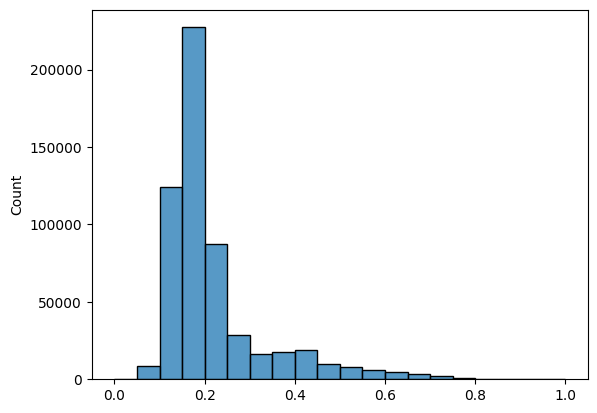

In [155]:
sns.histplot(chembl_pw_morgan, bins=np.arange(0,1.01, 0.05))

### 4. Visual inspection.

a) Transform the triangular matrix into a square matrix

In [156]:
chembl_pw_morgan = squareform(chembl_pw_morgan)

b) Build a dataframe with the results

In [177]:
chembl_sim_summary = pd.DataFrame({"A":np.where(chembl_pw_morgan)[0],
                                   "B":np.where(chembl_pw_morgan)[1],
                                   "Sim":chembl_pw_morgan[np.where(chembl_pw_morgan)]})
chembl_sim_summary.head()

,A,B,Sim
0,0,1,0.100000
1,0,2,0.147727
2,0,3,0.107143
3,0,4,0.104167
4,0,5,0.566667


c) Define a function to visualize a set of molecules from the ChEMBL dataset from their indexes

In [176]:
def draw_molecules_by_index(list_of_indexes):
  mols = []
  legends = []
  for ix in list_of_indexes:
    mols.append(Chem.MolFromSmiles(chembl_data.iloc[ix]["Smiles"]))
    legends.append(str(chembl_data.iloc[ix]["pChEMBL Value"]))
  return Draw.MolsToGridImage(mols, legends=legends, subImgSize=(300,300))

d) Visualize some examples

In [237]:
chembl_sim_summary[chembl_sim_summary["Sim"] > 0.4].sort_values("Sim").head()

,A,B,Sim
586170,551,1009,0.401961
556347,523,922,0.401961
979687,922,523,0.401961
585895,551,734,0.401961
1072109,1009,551,0.401961


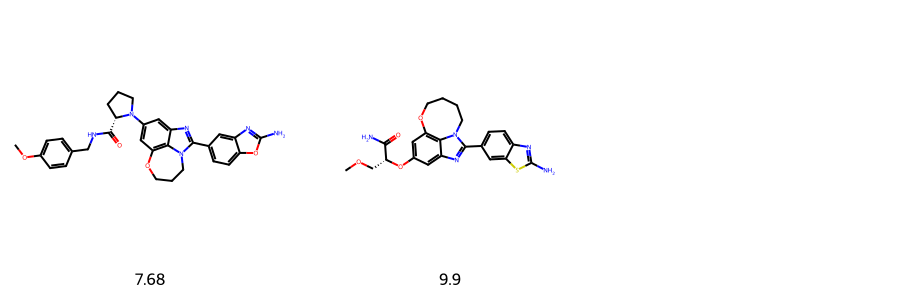

In [238]:
draw_molecules_by_index([551,1009])

### 5. Definition of a query.

Identify the most similar benzoxazole (from our generated dataset) to any of the bioactive compounds from ChEMBL

a) Calculate the pair-wise similarity between the benzoxazole dataset and the reference dataset from ChEMBL

In [183]:
pw_sim = 1 - cdist(benz_morgan, chembl_morgan, metric="jaccard")

b) Identify the highest similarity between a pair of compounds

In [195]:
pw_sim.max()

np.float64(0.4385964912280702)

c) Identify the indexes associated to such pair of compounds

In [203]:
np.where(pw_sim == pw_sim.max())

(array([900]), array([151]))

d) Visualize them

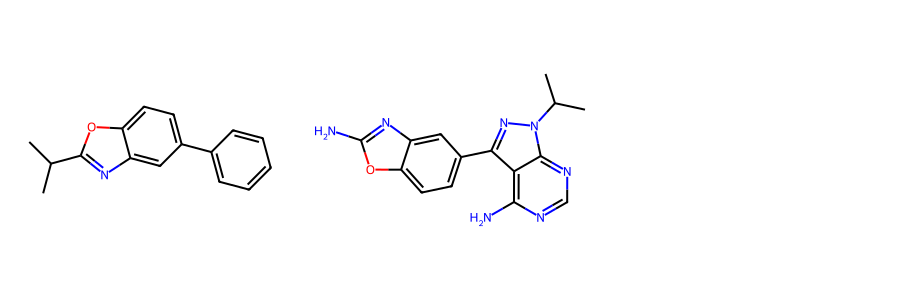

In [194]:
mols2draw = [Chem.MolFromSmiles(benzoxazoles.iloc[674]["Smiles"]), Chem.MolFromSmiles(chembl_data.iloc[252]["Smiles"])]
Draw.MolsToGridImage(mols2draw, subImgSize=(300,300))

In [199]:
chembl_data.iloc[252]

,252
Molecule ChEMBL ID,CHEMBL3545097
Smiles,CC(C)n1nc(-c2ccc3oc(N)nc3c2)c2c(N)ncnc21
pChEMBL Value,6.82
Assay ChEMBL ID,CHEMBL5533376


e) Include the activity value of the most similar compounds in the chembl dataset as an additional criterion to proritize compounds from the benzoxazoles dataset.

In [228]:
benzoxazoles["Max Sim"] = pw_sim.max(axis=1)
benzoxazoles["Nearest Compound Idx"] = np.argmax(pw_sim, axis=1)
benzoxazoles["Nearest Compound pChEMBL Value"] = chembl_data.iloc[list(benzoxazoles["Nearest Compound Idx"])]["pChEMBL Value"].reset_index(drop=True)
benzoxazoles.head()

,colummn,Smiles,Max Sim,Nearest Compound Idx,Nearest Compound pChEMBL Value
0,CC=Nc1nc2cc(-c3ccccc3)ccc2o1,CC=Nc1nc2cc(-c3ccccc3)ccc2o1,0.305085,252,6.82
1,Cc1ccc(/C=C/c2nc3cc4ccccc4cc3o2)cc1,Cc1ccc(/C=C/c2nc3cc4ccccc4cc3o2)cc1,0.241935,252,6.82
2,Cc1cc(C)c(Nc2nc3cc4ccccc4cc3o2)c(C)c1,Cc1cc(C)c(Nc2nc3cc4ccccc4cc3o2)c(C)c1,0.261538,231,6.75
3,CCC(C)(C)c1ccc2o[13c](C)nc2c1,CCC(C)(C)c1ccc2oc(C)nc2c1,0.316667,231,6.75
4,O=C1c2ccccc2C(=O)N1CCc1nc2c(ccc3ccccc32)o1,O=C1c2ccccc2C(=O)N1CCc1nc2c(ccc3ccccc32)o1,0.219178,151,6.40


<Axes: xlabel='Max Sim', ylabel='Nearest Compound pChEMBL Value'>

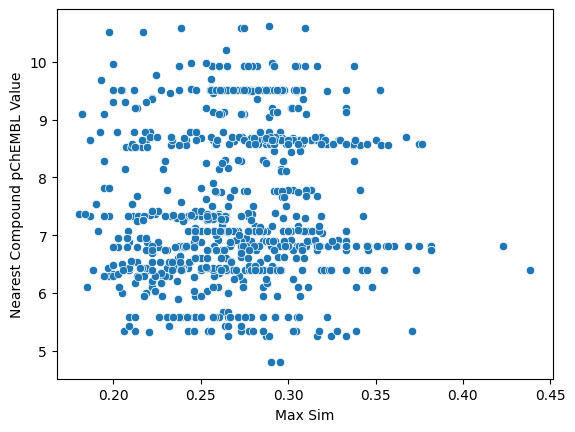

In [229]:
sns.scatterplot(data=benzoxazoles, x="Max Sim", y="Nearest Compound pChEMBL Value")

In [232]:
benzoxazoles[(benzoxazoles["Nearest Compound pChEMBL Value"] > 8) & (benzoxazoles["Max Sim"] > 0.35)].sort_values("Max Sim")

,colummn,Smiles,Max Sim,Nearest Compound Idx,Nearest Compound pChEMBL Value
802,CCC(C)(C)c1ccc2oc(N3CCN(C(=O)c4ccc(C)cc4)CC3)n...,CCC(C)(C)c1ccc2oc(N3CCN(C(=O)c4ccc(C)cc4)CC3)n...,0.352273,975,9.51
199,O=C(OCc1ccccc1)N1CCCC(c2nc3cc(-c4ccccc4)ccc3o2)C1,O=C(OCc1ccccc1)N1CCCC(c2nc3cc(-c4ccccc4)ccc3o2)C1,0.352941,834,8.56
608,O=C(OCc1ccccc1)N1CC[C@@H](c2nc3cc(-c4ccccc4)cc...,O=C(OCc1ccccc1)N1CC[C@@H](c2nc3cc(-c4ccccc4)cc...,0.357143,834,8.56
382,CN[13c]1nc2cc(-c3ccccc3)ccc2o1,CNc1nc2cc(-c3ccccc3)ccc2o1,0.367647,859,8.70
653,CNc1nc2cc(-c3ccccc3)ccc2o1,CNc1nc2cc(-c3ccccc3)ccc2o1,0.367647,859,8.70
76,CC(C)(C)OC(=O)N1CCC(c2ccc(F)cc2)(c2nc3cc(-c4cc...,CC(C)(C)OC(=O)N1CCC(c2ccc(F)cc2)(c2nc3cc(-c4cc...,0.375000,839,8.57
510,CC(C)(C)OC(=O)N1CCC(c2ccc(F)cc2)(c2nc3cc4ccccc...,CC(C)(C)OC(=O)N1CCC(c2ccc(F)cc2)(c2nc3cc4ccccc...,0.376471,839,8.57


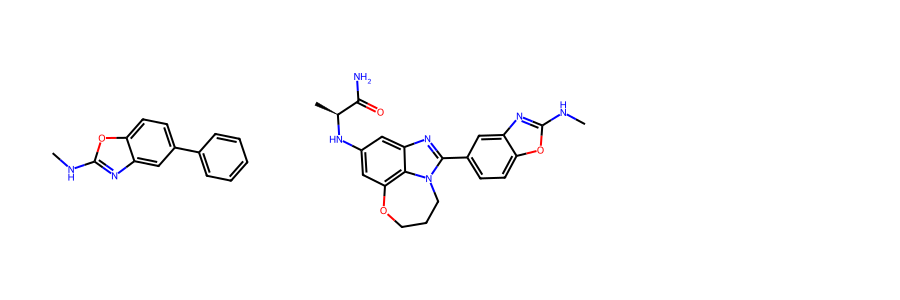

In [236]:
mols2draw = [Chem.MolFromSmiles(benzoxazoles.iloc[382]["Smiles"]), Chem.MolFromSmiles(chembl_data.iloc[859]["Smiles"])]
Draw.MolsToGridImage(mols2draw, subImgSize=(300,300))

## Bioactivity prediction

### 1. Endpoint definition.

We will build a binary classifier of compounds (strong inhibition / weak inhibition)

a) Visualize the distribution of activity values

<Axes: xlabel='pChEMBL Value', ylabel='Count'>

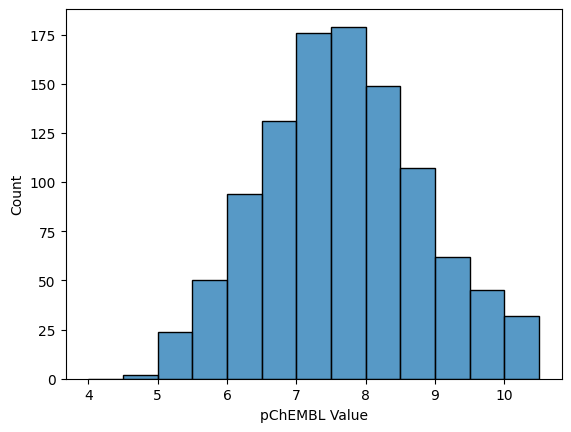

In [243]:
sns.histplot(data=chembl_data, x="pChEMBL Value", bins=np.arange(4,11,0.5))

b) Define a threshold to assign labels

In [248]:
model_data = chembl_data[(chembl_data["pChEMBL Value"] < 7) | (chembl_data["pChEMBL Value"] > 8)].copy().reset_index(drop=True)
model_data["Label"] = model_data["pChEMBL Value"].apply(lambda x: x > 8)

<Axes: xlabel='pChEMBL Value', ylabel='Count'>

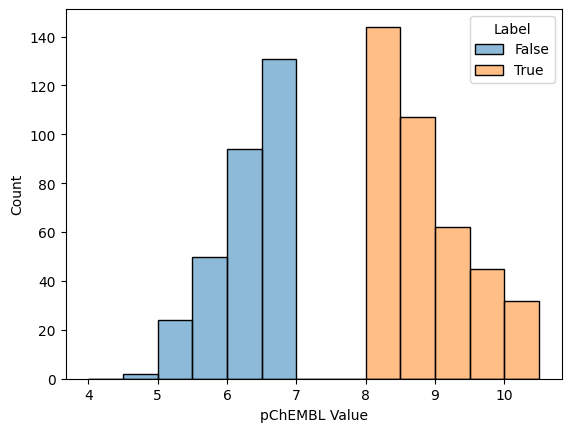

In [249]:
sns.histplot(data=model_data, x="pChEMBL Value", bins=np.arange(4,11,0.5), hue="Label")

### 2. Model building and evaluation.

a) Split the dataset into two subsets: a) model building and b) model testing

In [266]:
model_building, model_test = train_test_split(model_data.index, train_size=0.80, random_state=42)

In [267]:
model_train, model_val = train_test_split(model_building, train_size=0.75, random_state=42)

In [268]:
len(model_train), len(model_val), len(model_test)

(421, 141, 141)

b) Compute a set of descriptors to train the model

In [270]:
model_morgan = pd.DataFrame([morgan_gen.GetFingerprintAsNumPy(Chem.MolFromSmiles(x)) for x in tqdm(model_data["Smiles"])])
model_morgan.head()

100%|██████████| 703/703 [00:00<00:00, 1049.39it/s]


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


c) Define and train the model

In [286]:
classifier = KNeighborsClassifier(n_neighbors=1, metric="jaccard")
classifier.fit(X=model_morgan.iloc[model_train], y=model_data.iloc[model_train]["Label"])

KNeighborsClassifier(metric='jaccard', n_neighbors=1)

d) Evaluate the performance of the model in the validation set

In [287]:
train_pred = classifier.predict(X=model_morgan.iloc[model_train])
val_pred = classifier.predict(X=model_morgan.iloc[model_val])

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [288]:
train_ba = balanced_accuracy_score(y_true=model_data.iloc[model_train]["Label"], y_pred=train_pred)
train_ba

np.float64(1.0)

In [285]:
val_ba = balanced_accuracy_score(y_true=model_data.iloc[model_val]["Label"], y_pred=val_pred)
val_ba

np.float64(0.9125671765192229)

e) This process can be repeated with different hyperparameter selections

In [297]:
results = []
for i in np.arange(1,10,2):
  classifier = KNeighborsClassifier(n_neighbors=i, metric="jaccard")
  classifier.fit(X=model_morgan.iloc[model_train], y=model_data.iloc[model_train]["Label"])
  train_pred = classifier.predict(X=model_morgan.iloc[model_train])
  val_pred = classifier.predict(X=model_morgan.iloc[model_val])
  train_ba = balanced_accuracy_score(y_true=model_data.iloc[model_train]["Label"], y_pred=train_pred)
  val_ba = balanced_accuracy_score(y_true=model_data.iloc[model_val]["Label"], y_pred=val_pred)
  results.append({"Neighbors": i, "Train BA": train_ba, "Val BA": val_ba})
pd.DataFrame(results)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/me

,Neighbors,Train BA,Val BA
0,1,1.000000,0.936957
1,3,0.949831,0.927139
2,5,0.909396,0.912567
3,7,0.898160,0.901716
4,9,0.860533,0.878669


f) Evaluate the best configuration on the test set

In [299]:
classifier = KNeighborsClassifier(n_neighbors=1, metric="jaccard")
classifier.fit(X=model_morgan.iloc[model_building], y=model_data.iloc[model_building]["Label"])
train_pred = classifier.predict(X=model_morgan.iloc[model_building])
test_pred = classifier.predict(X=model_morgan.iloc[model_test])
train_ba = balanced_accuracy_score(y_true=model_data.iloc[model_building]["Label"], y_pred=train_pred)
test_ba = balanced_accuracy_score(y_true=model_data.iloc[model_test]["Label"], y_pred=test_pred)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [300]:
print(test_ba)

0.8790584415584415


### 3. Model application.

a) Apply the model in our generated library

In [302]:
benzoxazoles["Predicted Label"] = classifier.predict(X=benz_morgan)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [303]:
benzoxazoles["Predicted Label"].value_counts()

,count
Predicted Label,
False,523
True,383


### 4. Applicability domain.

In [323]:
model_data["Nearest Distance"] = classifier.kneighbors(X=model_morgan, n_neighbors=2)[0][:,1]

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [324]:
benzoxazoles["Nearest Distance"] = classifier.kneighbors(X=benz_morgan, n_neighbors=1)[0].flatten()

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


<Axes: xlabel='Nearest Distance', ylabel='Count'>

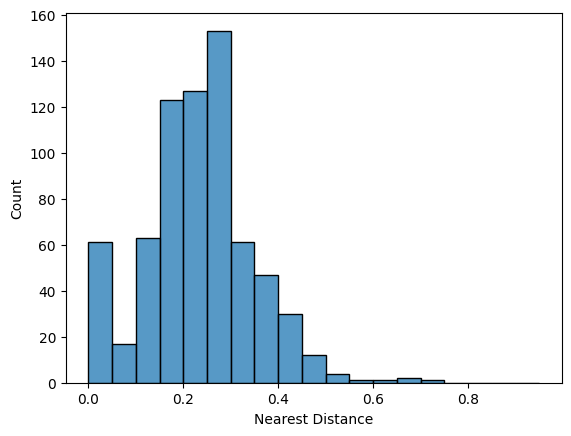

In [339]:
sns.histplot(model_data["Nearest Distance"], bins=np.arange(0,1,0.05))

In [347]:
model_data["Nearest Distance"].quantile(0.99)

np.float64(0.5171743295019158)

<Axes: xlabel='Nearest Distance', ylabel='Count'>

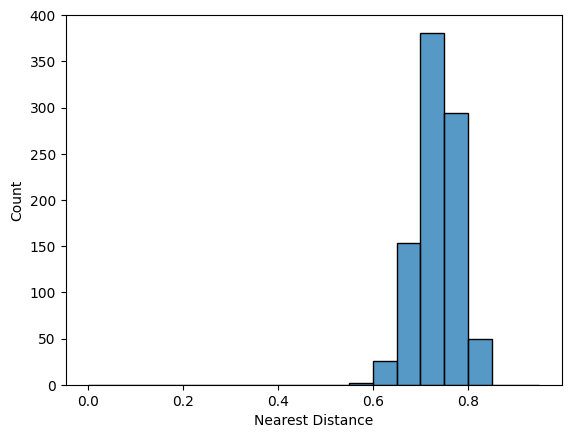

In [346]:
sns.histplot(benzoxazoles["Nearest Distance"], bins=np.arange(0,1,0.05))

In [348]:
benzoxazoles[benzoxazoles["Nearest Distance"] < model_data["Nearest Distance"].quantile(0.99)]["Predicted Label"].value_counts()

,count
Predicted Label,
